# **Phase 1 Modeling**

## Objectives:

Now that we have our feature set that we want, we will dive into modeling for this first phase, in which we are predicting the min_standard_value for bioactivity of our molecules.  This will be very foundational for the rest of the project.

In this notebook we will examine our ph1_df dataframe, and model it with XGBoost, RandomForest and SVR; hypertuning with BayesOpt and then looking at R2 and MSE for metrics before plotting the residuals.  We will conduct 3 different models in order to compare them before looking at a metrics table to view overall results. 

#### Just as we did in our other notebook formats, let's read in our data for this notebook as well as the appropriate libraries.

In [1]:
# Reading in libraries needed.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import HistGradientBoostingRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from skopt import BayesSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Read in our subject df for this notebook.
file_path = "/home/azureuser/cloudfiles/code/Users/kalpha1865/BioPred/Data/df_files/modeling_phase_1.parquet"
ph1_df = pd.read_parquet(file_path)

print(ph1_df.head())
print(ph1_df.shape)

                                 morgan_fingerprints  chi1_target_mean  \
0  0000000000000000000000000000000000000000000000...              3.06   
1  0000000000000000000000000000000000000000000000...              3.06   
2  0000000000000000000000000000000000000000000000...              3.38   
3  0000000000000000000000000000000000000000000000...              2.93   
4  0000000000000010000000000000000000000000000000...              3.01   

   min_standard_value  bertz_ct_target_mean  tid_target_mean  psa_target_mean  \
0                4.62                  3.68             3.32             3.32   
1                3.43                  3.68             3.32             3.32   
2                4.56                  4.56             3.32             3.32   
3                0.41                  3.37             3.34             2.54   
4                3.55                  1.74             3.34             2.65   

   full_mwt_target_mean  labute_asa_target_mean  hba_lipinski  aroma

#### Before we begin we will need to formally convert our Morgan Fingerprints into NumPy arrays.  They are still in ExplicitBitVect form, which are unusable at this time.

In [3]:
# Isolate and convert to arrays
X_fingerprints = np.vstack(ph1_df['morgan_fingerprints'].apply(lambda fp: np.array(list(fp), dtype = np.uint8)))

# Drop the original column from the df
ph1_df.drop(columns = ['morgan_fingerprints'], inplace = True)

# confirm shape
print(f"Fingerprint matrix shape: {X_fingerprints.shape}")

Fingerprint matrix shape: (343659, 2048)


#### Great we can see that the shape is being represented as 2D, with the correct rows and 2048 bits.  Good to go.

#### Now let's set up our models that we will use with our X,y and our train_test_split.

In [4]:
# X,y variables
X_numerical = ph1_df.drop(columns = ['min_standard_value']) # Drop target
X = np.hstack([X_fingerprints, X_numerical.values]) # Add the Morgan Fingerprints back in
y = ph1_df['min_standard_value'].values

In [5]:
# Train_test_split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#### Now we will run all 3 of our subject models, and using BayesOpt on each of them.  We will look at the MSE and R2 metrics for each of them and compare, as well as plotting residuals.

In [6]:
# Define the models for the third batch
models_tre = {
    'HistGradientBoosting': HistGradientBoostingRegressor(
        loss='squared_error',
        learning_rate=0.1,
        max_iter=100,
        max_depth=None,
        min_samples_leaf=20,
        max_bins=255,
        random_state=42
    ),

    'ExtraTrees': ExtraTreesRegressor(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        bootstrap=False,
        n_jobs=-1,
        random_state=42
    ),

    'GradientBoosting': GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=100,
        max_depth=3,
        min_samples_split=2,
        min_samples_leaf=1,
        subsample=0.8,
        random_state=42
    )
}


Training HistGradientBoosting...
HistGradientBoosting - MSE: 0.9130, R2: 0.5460


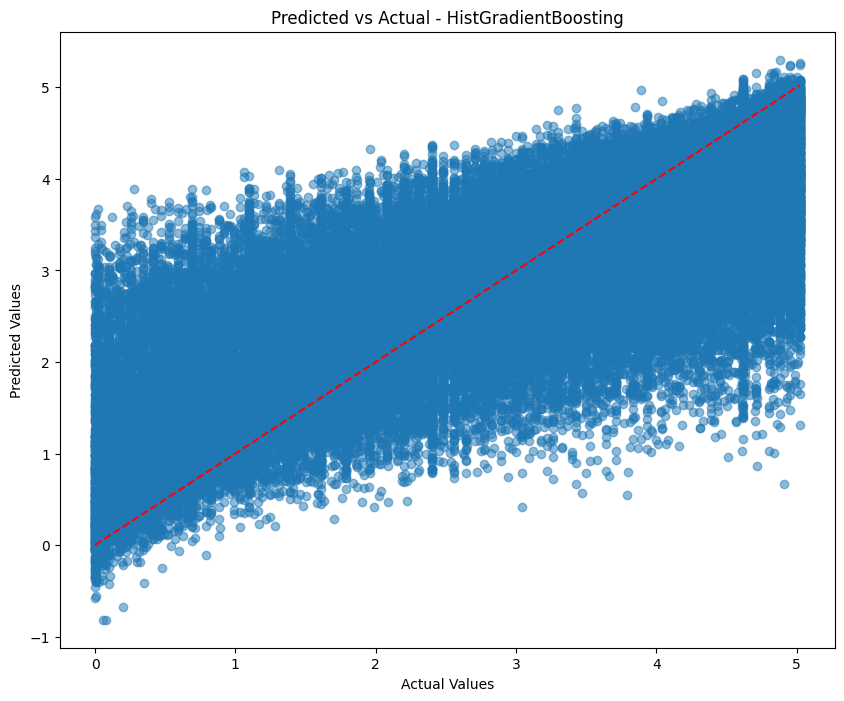

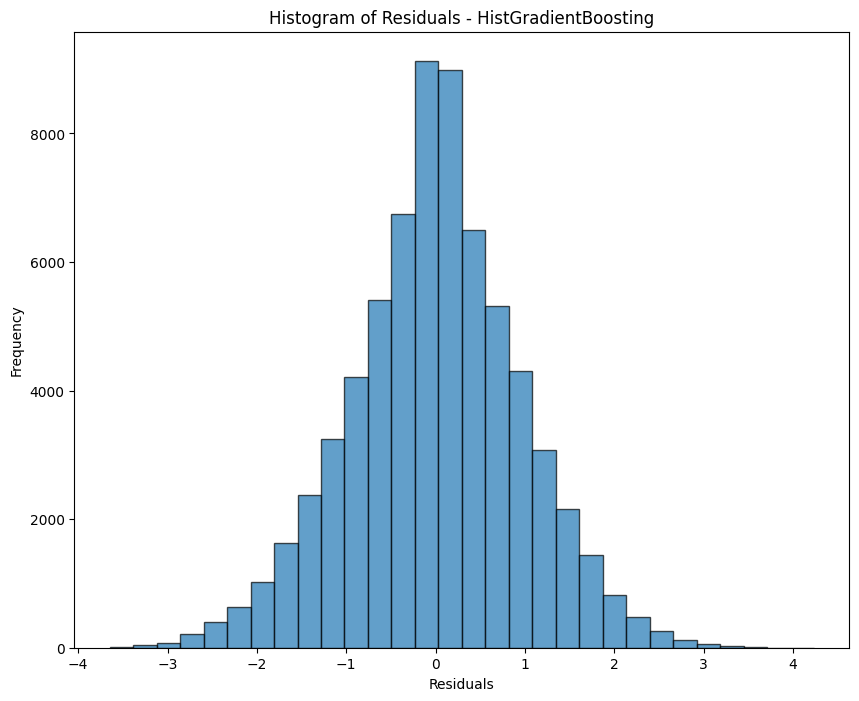


Training ExtraTrees...
ExtraTrees - MSE: 0.8726, R2: 0.5661


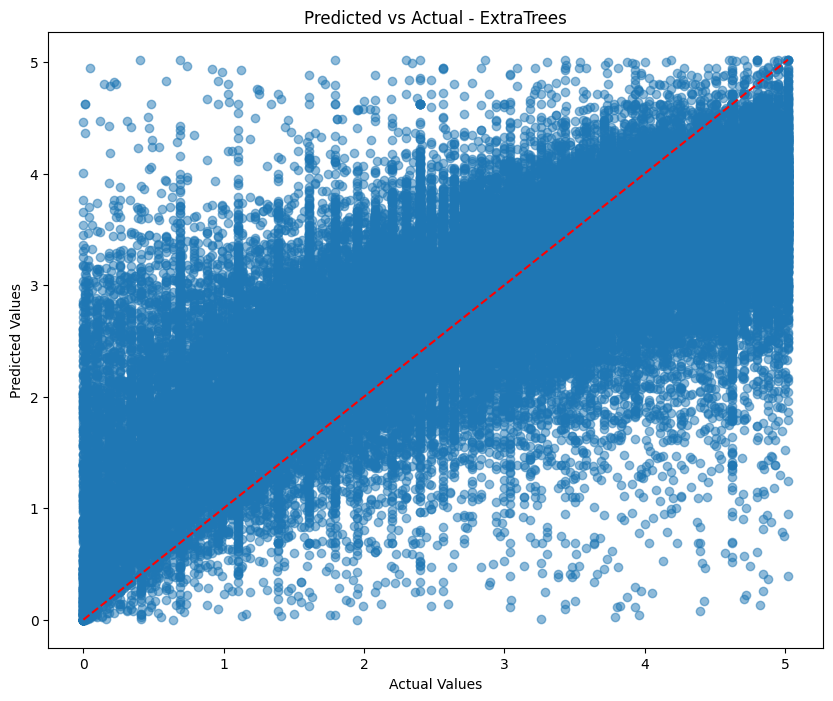

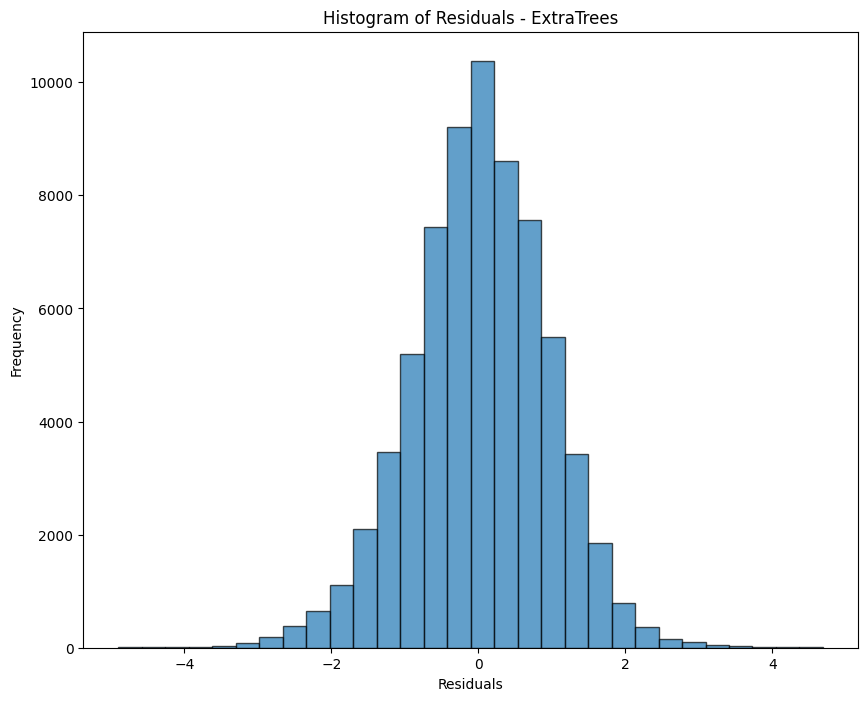


Training GradientBoosting...
GradientBoosting - MSE: 0.9518, R2: 0.5267


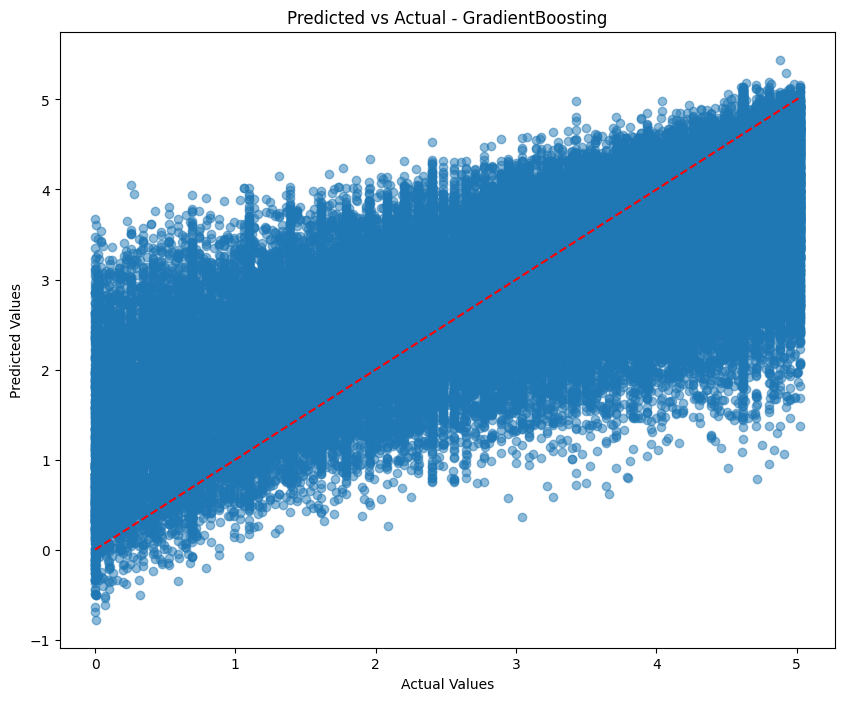

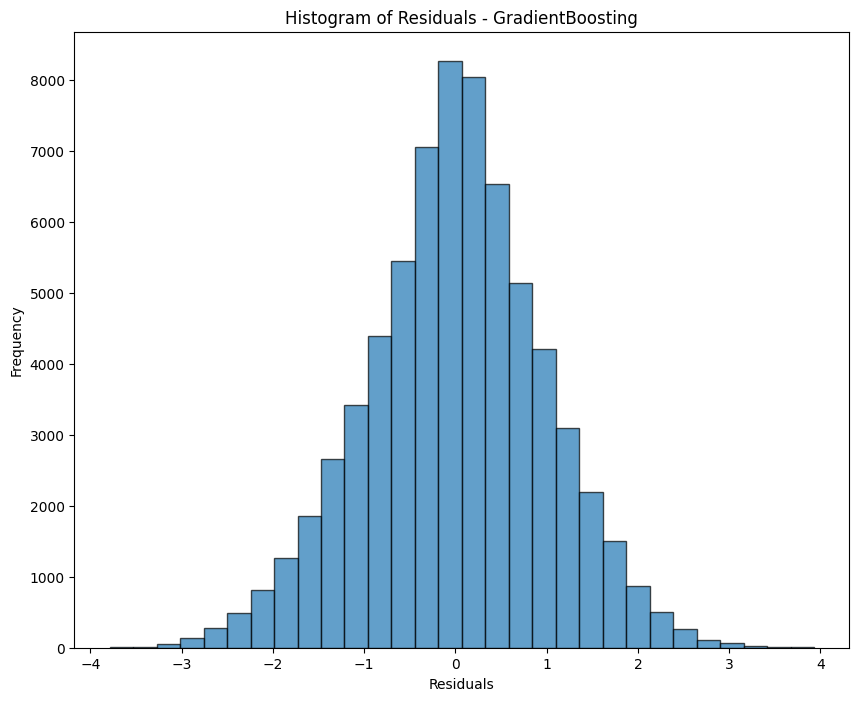

In [7]:
# Initial model runs and evaluation
results_initial_tre = {}

for name, model in models_tre.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results_initial_tre[name] = {'MSE' : mse, 'R2' : r2}
    print(f"{name} - MSE: {mse:.4f}, R2: {r2:.4f}")
    
    # Predicted vs Actual plots
    plt.figure(figsize = (10,8))
    plt.scatter(y_test, y_pred, alpha = 0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs Actual - {name}")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.show()
    
    # Histogram of Residuals
    plt.figure(figsize = (10,8))
    plt.hist(y_test - y_pred, bins = 30, alpha = 0.7, edgecolor = 'black')
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Residuals - {name}")
    plt.show()

In [8]:
# Hyperparameter spaces for BayesOpt
search_spaces_tre = {
    'HistGradientBoosting': {
        'learning_rate': (0.01, 0.3, 'log-uniform'),
        'max_iter': (100, 500),
        'max_depth': (3, 20),
        'min_samples_leaf': (5, 50),
        'max_bins': (128, 512)
    },
    'ExtraTrees': {
        'n_estimators': (100, 500),
        'max_depth': (5, 50),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 10),
        'max_features': ['sqrt', 'log2', None]
    },
    'GradientBoosting': {
        'learning_rate': (0.01, 0.3, 'log-uniform'),
        'n_estimators': (100, 500),
        'max_depth': (3, 20),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 10),
        'subsample': (0.5, 1.0)
    }
}

In [9]:
# Perform the Bayes Optimization
optimized_models_tre = {}

for name, model in models_tre.items():
    print(f"Optimizing {name}...")
    opt = BayesSearchCV(
        model, search_spaces_tre[name], n_iter = 20, cv = 3, scoring = 'r2', n_jobs = 2, random_state = 42
    )
    opt.fit(X_train, y_train)
    optimized_models_tre[name] = opt.best_estimator_
    print(f"Best params for {name}: {opt.best_params_}")

Optimizing HistGradientBoosting...


InvalidParameterError: The 'max_bins' parameter of HistGradientBoostingRegressor must be an int in the range [2, 255]. Got 407 instead.

In [ ]:
# Evaluate the models
results_optimized_tre = {}

for name, model in optimized_models_tre.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results_optimized_tre[name] = {'MSE' : mse, 'R2' : r2}

    # Plot residuals for each model
    plt.figure(figsize = (10, 8))
    plt.scatter(y_test, y_test - y_pred, alpha = 0.5)
    plt.axhline(y = 0, color = 'r', linestyle = '--')
    plt.xlabel("Actual Values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals Plot - {name}")
    plt.show()
    
    # Feature Importances for the Tree-Based Models
    if name in ['HistGradientBoosting', 'ExtraTrees', 'GradientBoosting']:
        importances = model.feature_importances_
        sorted_idx = np.argsort(importances)
        plt.figure(figsize = (10, 8))
        plt.barh(X.columns[sorted_idx], importances[sorted_idx], color = 'orange')
        plt.xlabel("Feature Importance")
        plt.ylabel("Feature")
        plt.title(f"Feature Importance - {name}")
        plt.show()

In [ ]:
# Display Results
results_initial_df_tre = pd.DataFrame(results_initial_tre).T
results_optimized_df_tre = pd.DataFrame(results_optimized_tre).T

print("\nInitial Model Results:")
print(results_initial_df_tre)
print("\nOptimized Model Results:")
print(results_optimized_df_tre)